### Imports

In [12]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


# fdsn client for connecting with web services, data pull
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

import warnings
warnings.filterwarnings("ignore")

#import geopandas
import geopandas as gpd
from geopandas import GeoDataFrame

### Get lat/lon coordinates for desired area

In [2]:
df_lat = pd.read_csv('./data_in/usa_county_bounding_boxes_v1.csv')
print(df_lat.shape)
print(df_lat.columns)

(3234, 10)
Index(['STATE_NAME', 'COUNTY_NAME', 'NAMELSAD', 'xmin', 'ymin', 'xmax', 'ymax',
       'GEOID', 'STATEFP', 'COUNTYFP'],
      dtype='object')


In [3]:
#df_sel1 = df_lat[(df_lat['COUNTY_NAME'] == "Los Angeles") |
#                 (df_lat['COUNTY_NAME'] == "Kern") |
#                 (df_lat['COUNTY_NAME'] == "Santa Barbara") |
#                 (df_lat['COUNTY_NAME'] == "San Luis Obispo") |
#                 (df_lat['COUNTY_NAME'] == "Ventura") |
#                 (df_lat['COUNTY_NAME'] == "San Bernadino") |
#                 (df_lat['COUNTY_NAME'] == "Riverside") | 
#                 (df_lat['COUNTY_NAME'] == "Orange") |
#                 (df_lat['COUNTY_NAME'] == "San Diego") |
#                 (df_lat['COUNTY_NAME'] == "Imperial") |
#                 (df_lat['COUNTY_NAME'] == "Clark") 
#                ]

#df_sel1 = df_lat[(df_lat['COUNTY_NAME'] == "Los Angeles")]

df_sel1 = df_lat[(df_lat['COUNTY_NAME'] == "Los Angeles") |
                 (df_lat['COUNTY_NAME'] == "Kern") 
                ]

df_sel1.head(3)

,STATE_NAME,COUNTY_NAME,NAMELSAD,xmin,ymin,xmax,ymax,GEOID,STATEFP,COUNTYFP
206,California,Kern,Kern County,-120.194369,34.788655,-117.616517,35.798392,6029,6,29
210,California,Los Angeles,Los Angeles County,-118.951721,32.750040,-117.646374,34.823302,6037,6,37


### Get seismic data

In [4]:
iris_client = Client("IRIS", timeout=600)

In [5]:
cat = iris_client.get_events(minlat=32,
                           maxlat=36, #35,
                           minlon=-121, #-119,
                           maxlon=-117,
                           starttime=UTCDateTime("2019-01-01"),
                           endtime=UTCDateTime("2023-02-28"),
                           minmag=0.0) # 2.0
cat

75420 Event(s) in Catalog:
2023-02-26T23:02:26.650000Z | +35.302, -118.534 | 2.05 Ml
2023-02-26T20:10:50.080000Z | +35.085, -117.126 | 1.86 Ml
...
2019-01-01T04:13:56.310000Z | +34.045, -117.252 | 1.46 Ml
2019-01-01T01:29:12.300000Z | +35.867, -120.330 | 1.1 Md
To see all events call 'print(CatalogObject.__str__(print_all=True))'

In [6]:
times = []
lats = []
lons = []
deps = []
magnitudes = []
magnitudestype = []
for event in cat:
    if len(event.origins) != 0 and len(event.magnitudes) != 0:
        times.append(event.origins[0].time.datetime)
        lats.append(event.origins[0].latitude)
        lons.append(event.origins[0].longitude)
        deps.append(event.origins[0].depth)
        magnitudes.append(event.magnitudes[0].mag)
        magnitudestype.append(event.magnitudes[0].magnitude_type )

In [7]:
#df = pd.DataFrame({'lat':lats,'lon':lons,'depth':deps,
#                   'mag':magnitudes,'type':magnitudestype}, 
#                  index = times)

df = pd.DataFrame({'datetime':times, 'lat':lats,'lon':lons,'depth':deps,
                   'mag':magnitudes,'type':magnitudestype})

print(df.shape)
print(df.columns)
display(df.head(4))
display(df.tail(4))

(75420, 6)
Index(['datetime', 'lat', 'lon', 'depth', 'mag', 'type'], dtype='object')


,datetime,lat,lon,depth,mag,type
0,2023-02-26 23:02:26.650,35.301667,-118.534333,4930.0,2.05,Ml
1,2023-02-26 20:10:50.080,35.085333,-117.126333,3450.0,1.86,Ml
2,2023-02-26 19:26:15.550,35.641000,-117.456167,6920.0,2.81,Ml
3,2023-02-26 05:45:43.270,35.638667,-117.455333,9430.0,2.36,Ml


,datetime,lat,lon,depth,mag,type
75416,2019-01-01 09:55:28.190,34.014000,-117.211333,17470.0,1.00,Ml
75417,2019-01-01 04:38:31.230,34.209333,-117.408500,14600.0,1.29,Ml
75418,2019-01-01 04:13:56.310,34.044833,-117.252333,15920.0,1.46,Ml
75419,2019-01-01 01:29:12.300,35.867500,-120.330002,9070.0,1.10,Md


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [8]:
df = df.sort_values(by='datetime')
df = df.reset_index(drop=True)
display(df.head(3))
display(df.tail(3))

,datetime,lat,lon,depth,mag,type
0,2019-01-01 01:29:12.300,35.867500,-120.330002,9070.0,1.10,Md
1,2019-01-01 04:13:56.310,34.044833,-117.252333,15920.0,1.46,Ml
2,2019-01-01 04:38:31.230,34.209333,-117.408500,14600.0,1.29,Ml


,datetime,lat,lon,depth,mag,type
75417,2023-02-26 19:26:15.550,35.641000,-117.456167,6920.0,2.81,Ml
75418,2023-02-26 20:10:50.080,35.085333,-117.126333,3450.0,1.86,Ml
75419,2023-02-26 23:02:26.650,35.301667,-118.534333,4930.0,2.05,Ml


In [10]:
print(np.min(df['mag']))
print(np.max(df['mag']))

0.0
7.1


In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df['datetime'], df['mag'], '.');

In [ ]:
plt.figure()
plt.hist(df['mag'], bins=100);

In [ ]:
df.head(3)

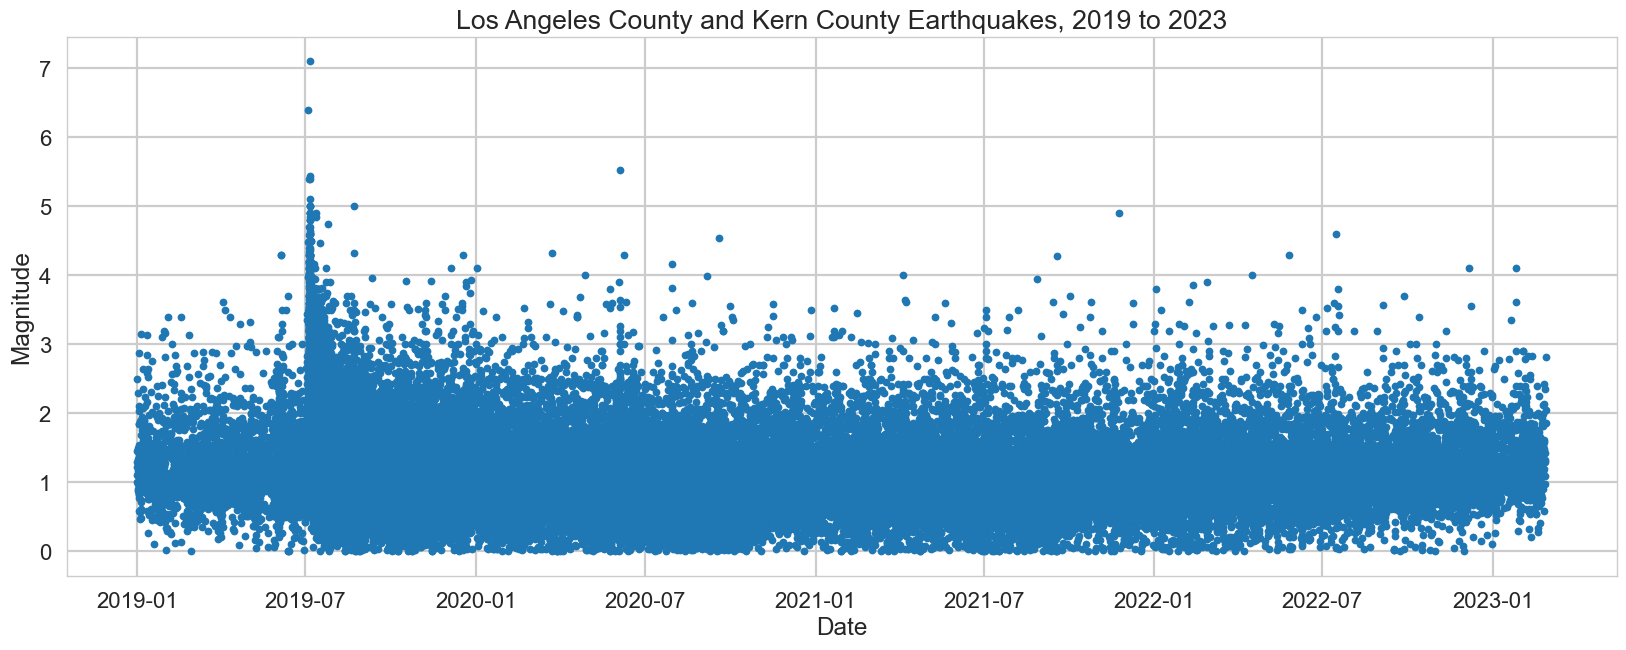

In [17]:
plt.figure(figsize=(20,7))
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.plot(df['datetime'], df['mag'], '.');
#plt.xlim(pd.to_datetime('2019-01-01'),pd.to_datetime('2020-01-01'));
plt.title('Los Angeles County and Kern County Earthquakes, 2019 to 2023')
plt.xlabel('Date')
plt.ylabel('Magnitude');

In [19]:
# df.to_csv('data_seismic_magnitudes_LA_Kern_20230226v1.csv', index=False)

### Ingest saved data

In [8]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import panel as pn
pn.extension()

In [6]:
df = []
df = pd.read_csv('./data_out/data_seismic_magnitudes_LA_Kern_20230226v1.csv')

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime')
df = df.reset_index(drop=True)

print(df.shape)
display(df.head())
display(df.tail())

(75420, 6)


,datetime,lat,lon,depth,mag,type
0,2019-01-01 01:29:12.300,35.867500,-120.330002,9070.0,1.10,Md
1,2019-01-01 04:13:56.310,34.044833,-117.252333,15920.0,1.46,Ml
2,2019-01-01 04:38:31.230,34.209333,-117.408500,14600.0,1.29,Ml
3,2019-01-01 09:55:28.190,34.014000,-117.211333,17470.0,1.00,Ml
4,2019-01-01 12:01:46.950,34.178167,-117.344667,8880.0,2.50,Ml


,datetime,lat,lon,depth,mag,type
75415,2023-02-26 04:48:37.640,34.464833,-117.951167,8650.0,0.97,Ml
75416,2023-02-26 05:45:43.270,35.638667,-117.455333,9430.0,2.36,Ml
75417,2023-02-26 19:26:15.550,35.641000,-117.456167,6920.0,2.81,Ml
75418,2023-02-26 20:10:50.080,35.085333,-117.126333,3450.0,1.86,Ml
75419,2023-02-26 23:02:26.650,35.301667,-118.534333,4930.0,2.05,Ml


### Creat visualization

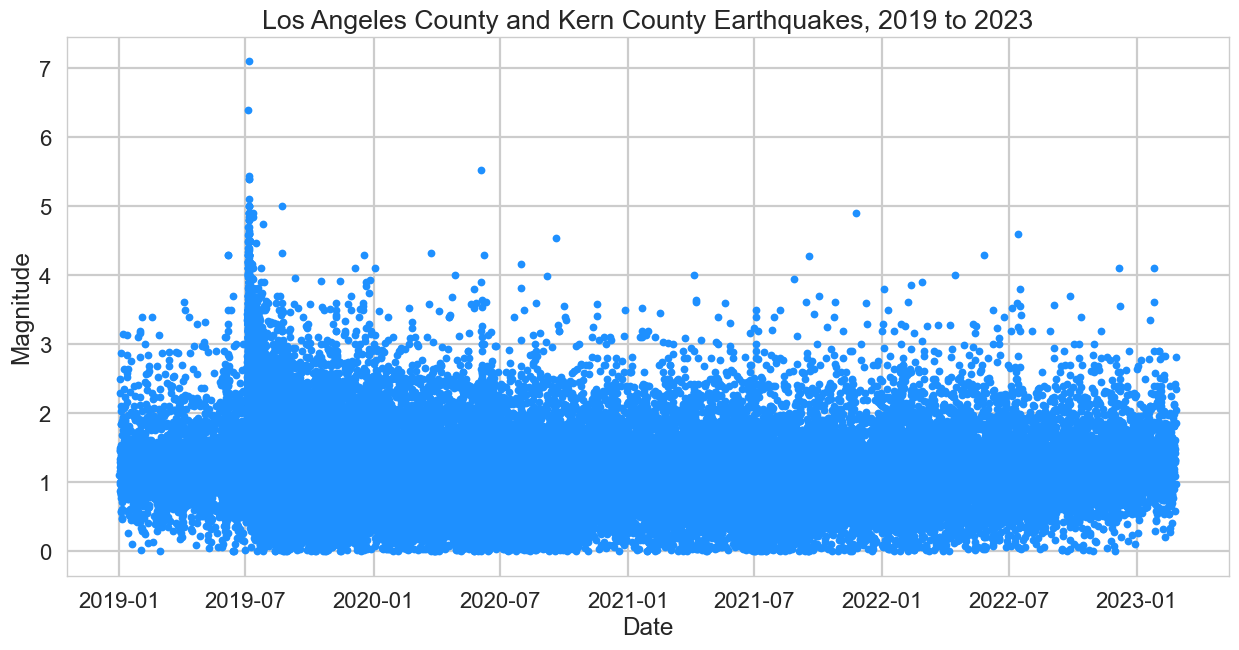

In [12]:
fig1 = plt.figure(figsize=(15,7)) # (20,7)

plt.style.use('default')
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')

plt.plot(df['datetime'], df['mag'], '.', color='dodgerblue');

#plt.title('SoCal Earthquakes Since 2019');
plt.title('Los Angeles County and Kern County Earthquakes, 2019 to 2023')
plt.xlabel('Date')
plt.ylabel('Magnitude');

### Creat data app with HoloViz Panel

In [13]:
app1 = pn.Column(pn.Row(fig1))

In [17]:
app2 = pn.template.FastListTemplate(site = 'Geology of Southern California',
                                    title= 'Seismic App-1',
                                    main = [app1], main_max_width="1768px").servable(); #theme='dark').servable();
                                    
app2.show()

Launching server at http://localhost:50870


In [ ]:
# cli launch multi-page app

# ! > python -m panel serve obspy_panelMultiPg1_v3.ipynb obspy_panelMultiPg1_v4.ipynb --autoreload

### Next Steps

#### Multi-page APP

Serving multiple apps with HoloViz Panel, Marc Skov Madsen,     
https://www.youtube.com/watch?v=REN0VH7Yq04       
https://discourse.holoviz.org/t/multi-page-app-documentation/3108

cli launch multi-page app:     
    > python -m panel serve obspy_panelMultiPg1_v3.ipynb obspy_panelMultiPg1_v4.ipynb --autoreload
    
#### Map earthquake events   

GeoPandas or Plotly: https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6   

GeoPandas plus Contextily: https://geopandas.org/en/stable/gallery/plotting_basemap_background.html   

Contextily local: https://contextily.readthedocs.io/en/latest/working_with_local_files.html